In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import re
from datetime import datetime as dt
import time
import csv
import requests
import urllib.parse

import json
import nltk

# Analysis of Steam Game Descriptions
In the course of my [Steam game data analysis project,](https://github.com/isam7/SteamScraping) I scraped descriptions and user reviews of Steam games. I thought it would be interesting to see what insights could be gleaned by a little natural language processing analysis of this data. I will start with the game descriptions data.

## Data Cleaning
Before we can start the fun of exploring the data, I will need to first import and clean it.

In [2]:
rawGames = pd.read_csv('SteamAppsInfo.csv', encoding = "ISO-8859-1")

In [3]:
rawGames

appId                    name                  developerName  \
0       1688200             War Of Gold  Tero Lunkka,Valkeala Software   
1       1688210                  Utopia                   Iconic Ideaz   
2       1688220            Fire & Reign                   Siphon Shock   
3       1688240  Escape from the Office   ParachuteGames, ImperiumGame   
4       1688250    PRINCESS IN AIRINESS                    Broken Desk   
...         ...                     ...                            ...   
113005  1972180                Dub Club          Cyberfunk Studios LLC   
113006  1595760             ScreenSpace                   Wave Project   
113007  1996680            Fowl Scourge                 Void Cup Games   
113008  1972250     Project: Maidenless     Grossly Incandescent Games   
113009   457260          Omen of Sorrow                     AOne Games   

           releaseDate  price  numReviews positiveReviewPercentage  \
0         Aug 22, 2021   0.59        15.0                      66%   
1          Jan 7, 2022    NaN         NaN                      NaN   
2             Jun 2022    NaN         NaN                      NaN   
3         Jul 26, 2021   2.99        12.0                      91%   
4         Jul 26, 2021   3.99         2.0                      NaN   
...                ...    ...         ...                      ...   
113005    May 20, 2022   0.00         NaN                      NaN   
113006    Apr 23, 2021   1.99         1.0                      NaN   
113007  When its done    NaN         NaN                      NaN   
113008             TBA    NaN         NaN                      NaN   
113009     coming soon    NaN         NaN                      NaN   

                                                 appGenre  \
0                           ['Action', 'Casual', 'Indie']   
1       ['Action', 'Adventure', 'Massively Multiplayer...   
2                                     ['Action', 'Indie']   
3                                     ['Action', 'Indie']   
4                                     ['Action', 'Indie']   
...                                                   ...   
113005                         ['Casual', 'Free to Play']   
113006                                ['Casual', 'Indie']   
113007                         ['Action', 'Indie', 'RPG']   
113008  ['Action', 'Adventure', 'Indie', 'Massively Mu...   
113009                                         ['Action']   

                                                 tagsList    appType  dlcBool  \
0       ['Casual', 'Action', '3D Fighter', 'Shooter', ...  All Games    False   
1       ['Early Access', 'RPG', 'Survival', 'Colorful'...  All Games    False   
2       ['Bullet Hell', 'Action', "Shoot 'Em Up", 'Sho...  All Games    False   
3       ['Action', 'Precision Platformer', 'Perma Deat...  All Games    False   
4       ['Action', 'Point & Click', '2D Platformer', '...  All Games    False   
...                                                   ...        ...      ...   
113005  ['Casual', 'Rhythm', 'Exploration', 'Third Per...  All Games    False   
113006  ['Casual', 'Clicker', 'Arcade', 'Point & Click...  All Games    False   
113007                                                 []  All Games    False   
113008  ['Early Access', 'Action', 'Adventure', 'RPG',...  All Games    False   
113009  ['PvP', '2D Fighter', '3D Fighter', 'Action', ...  All Games    False   

                                                  appDesc  alteredTextBool  
0       You super hero soldier need save robber gold b...            False  
1       UTOPIA is an open world survival game set in a...            False  
2       Upgrade your warriors and shoot through waves ...            False  
3       Escape from the Office is a 2D side-scrolling ...            False  
4       To pray for peace, the princess once again fli...            False  
...                                                   ...              ...  
113005  A third person multiplayer 

It turns out that Steam is filled with hundreds of games made by a developer called 'TigerQiuQiu'. This developer uploads one free game, e.g., "Tiger Tanks", and then uploads hundreds of map DLCs for it, all with the same app description. These app descriptions are filled with typos, and since they are all copy-pasted repeatedly, they can dramatically alter the frequency distribution of words in the data. To avoid this problem, I will simply drop all apps made by this developer, since they do not really contribute to the analysis in any interesting way.

In [4]:
#Remove all Tiger Tank games. There are a lot of these games, and they all have the same typos in their
#descriptions that mess up the analysis.
tiger_tank_bool = []

for game in rawGames.iterrows():
    try:
        if game[1]['developerName'] == 'TigerQiuQiu':
            tiger_tank_bool.append(False)
        else:
            tiger_tank_bool.append(True)
    except TypeError:
        tiger_tank_bool.append(True)
        
games = rawGames[tiger_tank_bool]

In [5]:
games.reset_index(inplace=True)

games

index    appId                    name  \
0            0  1688200             War Of Gold   
1            1  1688210                  Utopia   
2            2  1688220            Fire & Reign   
3            3  1688240  Escape from the Office   
4            4  1688250    PRINCESS IN AIRINESS   
...        ...      ...                     ...   
110765  113005  1972180                Dub Club   
110766  113006  1595760             ScreenSpace   
110767  113007  1996680            Fowl Scourge   
110768  113008  1972250     Project: Maidenless   
110769  113009   457260          Omen of Sorrow   

                        developerName     releaseDate  price  numReviews  \
0       Tero Lunkka,Valkeala Software    Aug 22, 2021   0.59        15.0   
1                        Iconic Ideaz     Jan 7, 2022    NaN         NaN   
2                        Siphon Shock        Jun 2022    NaN         NaN   
3        ParachuteGames, ImperiumGame    Jul 26, 2021   2.99        12.0   
4                         Broken Desk    Jul 26, 2021   3.99         2.0   
...                               ...             ...    ...         ...   
110765          Cyberfunk Studios LLC    May 20, 2022   0.00         NaN   
110766                   Wave Project    Apr 23, 2021   1.99         1.0   
110767                 Void Cup Games  When its done    NaN         NaN   
110768     Grossly Incandescent Games             TBA    NaN         NaN   
110769                     AOne Games     coming soon    NaN         NaN   

       positiveReviewPercentage  \
0                           66%   
1                           NaN   
2                           NaN   
3                           91%   
4                           NaN   
...                         ...   
110765                      NaN   
110766                      NaN   
110767                      NaN   
110768                      NaN   
110769                      NaN   

                                                 appGenre  \
0                           ['Action', 'Casual', 'Indie']   
1       ['Action', 'Adventure', 'Massively Multiplayer...   
2                                     ['Action', 'Indie']   
3                                     ['Action', 'Indie']   
4                                     ['Action', 'Indie']   
...                                                   ...   
110765                         ['Casual', 'Free to Play']   
110766                                ['Casual', 'Indie']   
110767                         ['Action', 'Indie', 'RPG']   
110768  ['Action', 'Adventure', 'Indie', 'Massively Mu...   
110769                                         ['Action']   

                                                 tagsList    appType  dlcBool  \
0       ['Casual', 'Action', '3D Fighter', 'Shooter', ...  All Games    False   
1       ['Early Access', 'RPG', 'Survival', 'Colorful'...  All Games    False   
2       ['Bullet Hell', 'Action', "Shoot 'Em Up", 'Sho...  All Games    False   
3       ['Action', 'Precision Platformer', 'Perma Deat...  All Games    False   
4       ['Action', 'Point & Click', '2D Platformer', '...  All Games    False   
...                                                   ...        ...      ...   
110765  ['Casual', 'Rhythm', 'Exploration', 'Third Per...  All Games    False   
110766  ['Casual', 'Clicker', 'Arcade', 'Point & Click...  All Games    False   
110767                                                 []  All Games    False   
110768  ['Early Access', 'Action', 'Adventure', 'RPG',...  All Games    False   
110769  ['PvP', '2D Fighter', '3D Fighter', 'Action', ...  All Games    False   

                                                  appDesc  alteredTextBool  
0       You super hero soldier need save robber gold b...            False  
1       UTOPIA is an open world survival game set in a...            False  
2       Upgrade your warriors and shoot through waves ...            False  
3       Escape from the Office is a 2D side-scro

Now that that's taken care of, I will proceed with cleaning the data in the same way I did in the original Steam project. The game release dates need to be standardized and the game tags need to have troublesome characters, such as apostrophes, removed.

In [6]:
#Now to try and get the dates.
#
#Note that this script eliminates dates which don't fit certain date formats.
#
#For example, it converts "Coming Soon" to NaN.
def datesCleaned(dataframe):
    
    datesCleaned = [];
    
    #Convert to dt format
    for i in dataframe['releaseDate']:
        try:
            datesCleaned.append(dt.strptime(i, '%b %d, %Y'))
        except:
            try:
                datesCleaned.append(dt.strptime(i, '%b, %Y'))
                
            except:
                try: datesCleaned.append(dt.strptime(i, '%b %Y'))
                    
                except:
                    datesCleaned.append(np.nan)
            
    datesCleanedSeries = pd.Series(datesCleaned)
    
    datesCleanedSeries.index = dataframe.index
    
    return datesCleanedSeries

datesCleaned = datesCleaned(games)

#Replece release dates with cleaned dates
games['releaseDate'] = datesCleaned
        
# #Add cleaned release dates to dataframes
# ncrpgs_df['releaseDate'] = rpgDatesCleaned[ncrpgs_df.index]
# crpgs_df['releaseDate'] = rpgDatesCleaned[crpgs_df.index]

C:\Users\phyis\AppData\Local\Temp\ipykernel_28728\3574825690.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['releaseDate'] = datesCleaned


In [7]:
#Clean all the game tags
def tagsCleaned(games_df):
    
    tagsCleaned = []
    
    for k in games_df.index:
        
        #Get rid of \' \s \em etc.
        tagsRemovedSlashes = re.findall(r"'(.*?)'[,\]]",games_df.tagsList[k]\
                                        .replace("\'s","s").replace("\'em","em")\
                                        .replace("\'Em","Em").replace("\'","''"))
        
        tagsCleaned.append([tagsRemovedSlashes[j].replace("'","") for j in range(len(tagsRemovedSlashes))])
        
    tagsCleanedSeries = pd.Series(tagsCleaned)
    
    tagsCleanedSeries.index = games_df.index
        
    return tagsCleanedSeries

games['tagsList'] = tagsCleaned(games)

print(games['tagsList'][0])

['Casual', 'Action', '3D Fighter', 'Shooter', 'Runner', 'Real Time Tactics', 'Hero Shooter', '3D', 'Military', 'Stealth', 'Flight', 'Survival', 'Story Rich', 'Combat', 'Singleplayer', 'Third-Person Shooter', 'Vehicular Combat', 'Indie', 'First-Person', 'Character Customization']


C:\Users\phyis\AppData\Local\Temp\ipykernel_28728\1009422152.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['tagsList'] = tagsCleaned(games)


In [28]:
# for i in range(101):
    
#     print(games['appDesc'][i],'\n')

With all the data cleaned, there is one more thing I must do before exploring the data: we need to tokenize the game descriptions. This will allow us to easily compute frequency descriptions and use other helpful functions from the nltk package. To that end, I will write a function that tokenizes a corpus which includes all apps of a certain genre (defined as having a specific tag).

In [43]:
import re

regex = re.compile('[^a-zA-Z]')
#First parameter is the replacement, second parameter is your input string
regex.sub('', 'ab3d*E')
#Out: 'abdE'

from nltk.tokenize import wordpunct_tokenize

def tokenize_app_description_genre(*genre,tag_cutoff=5,alphabet_only=False):
    #Tokenize app descriptions for a certain genre. If no genre is given, returns tokenized
    #app descriptions for all apps.
    #
    #tag_cutoff specifies the number of positions at the top of the tag list to check for a match on *genre
    #
    #alphabet_only removes all non-alphabet characters if True
    
    #Create Pandas Series of app descriptions in the genre
    if type(genre[0]) == str:
        
        #Create list of Boolean values indicating whether a game genre is in the top 5 elements of the app tag list
        genre_bools = []

        for app_tag_list in games['tagsList'].values:

            if genre[0] in app_tag_list[:tag_cutoff-1]:
                genre_bools.append(True)
            else:
                genre_bools.append(False)
        
        relevant_app_descriptions = games[genre_bools]['appDesc'].dropna().values
     
    #Else, create Pandas Series of all app descriptions
    else:
        relevant_app_descriptions = games['appDesc'].dropna().values
    
    #Create empty string to fill with all descriptions
    app_descriptions_raw = ''

    #Fill the string with app descriptions
    for description in relevant_app_descriptions:
        app_descriptions_raw = app_descriptions_raw + description
    
    #Conditionally remove characters that aren't alphabetical or spaces
    if alphabet_only:
        regex = re.compile('[^a-zA-Z ]')
        app_descriptions_raw = regex.sub('', app_descriptions_raw)
    
    #Convert upper to lowercase and tokenize
    app_descriptions_raw_lower = app_descriptions_raw.lower()
    app_descriptions = wordpunct_tokenize(app_descriptions_raw_lower)
        
    return app_descriptions

In [15]:
#Generate raw text containing all app descriptions
app_descriptions_raw = ''

for description in games['appDesc'].dropna():
    app_descriptions_raw = app_descriptions_raw + description

In [16]:
from nltk.tokenize import wordpunct_tokenize
from nltk.probability import FreqDist


#Convert all uppercase letters to lowercase and tokenize the text
app_descriptions_raw_lower = app_descriptions_raw.lower()
app_descriptions = wordpunct_tokenize(app_descriptions_raw_lower)

In [29]:
# app_descriptions

In [18]:
app_desc_word_freqs = FreqDist(word for word in app_descriptions)

In [19]:
app_desc_word_freqs.most_common(10)

[('the', 187694),
 ('.', 167480),
 (',', 151255),
 ('and', 119735),
 ('a', 114601),
 ('of', 94240),
 ('to', 89092),
 ('-', 64689),
 ('in', 64050),
 ('you', 54993)]

We can see from the above output that the most common words are, unsurprisingly, articles, punctuation, common prepositions, etc. We are not interested in how often these occur in different genres, however. This will present a problem in the exploratory analysis below, but I will offer an easy fix for it.

## Exploratory Analysis
With that, we can finally begin exploring the data! I will start with a look at RPGs (my favorite kind of game).

In [20]:
#Generate tokenized app descriptions of RPGs
app_desc_RPG = tokenize_app_description_genre('RPG')

In [21]:
app_desc_RPG_freqs = FreqDist(word for word in app_desc_RPG)
app_desc_RPG_freqs.most_common(10)

#Get relative frequency of RPG words out of the whole corpus
app_desc_RPG_relative_freqs = {}

for word in app_desc_word_freqs.keys():
    
    if app_desc_word_freqs[word] > 100:
        try:
            app_desc_RPG_relative_freqs[word] = app_desc_RPG_freqs[word]/app_desc_word_freqs[word]
        except:
            pass
    
RPG_words_series = pd.Series(app_desc_RPG_relative_freqs)

print(RPG_words_series.nlargest(100))

starfinder     0.993711
pathfinder     0.974359
5e             0.952756
roleplaying    0.925926
token          0.921196
                 ...   
crown          0.403061
rendered       0.401786
brink          0.398230
wasteland      0.394286
villains       0.394161
Length: 100, dtype: float64


The output just generated is the words from the RPG corpus which have the highest relative frequency when compared to the corpus of all games, conditional on the word occuring at least 100 times in the corpus of all games. The relative frequency is useful for eliminating words that are common in general, like "the" and "a". The requirement that the word appear at least 100 times is useful for removing typos or words that appear in only one game (e.g., the unique name of some game's main character).

This is interesting to explore because it tells us which words are relatively unique to RPGs. We can see that "starfinder" and "pathfinder" are very common among RPGs relative to all games, which makes sense. Starfinder and Pathfinder are two very common RPGs. It would be still more interesting to do this for a list of many different genres, so I will write a function to return the word frequencies for the corpus of any given genre.

In [48]:
#Print n_top most relatively frequent words in a genre's corpus and return a Pandas series of relative frequencies.
#Ignore words that appear less than n_cutoff times in the overall corpus.
def relative_freqs(genre,n_top=100,n_cutoff=100,tag_cutoff=5,alphabet_only=False):
    app_desc_genre = tokenize_app_description_genre(genre,tag_cutoff=tag_cutoff,alphabet_only=alphabet_only)
    
    app_desc_genre_freqs = FreqDist(word for word in app_desc_genre)
    
    #Get relative frequency of genre words out of the whole corpus
    app_desc_genre_relative_freqs = {}

    for word in app_desc_word_freqs.keys():

        #Make sure word appears more than n_cutoff. This helps avoid typos, etc.
        if app_desc_word_freqs[word] > n_cutoff:
            try:
                #Compute relative frequencies
                app_desc_genre_relative_freqs[word] = app_desc_genre_freqs[word]/app_desc_word_freqs[word]
            except:
                pass

    genre_words_series = pd.Series(app_desc_genre_relative_freqs)

#     print('{} most common words in {} game descriptions: \n'.format(n_cutoff,genre),\
#           genre_words_series.nlargest(n_top).keys())
    
    return genre_words_series

#Create function to count the frequency of tags in our dataframes
def count_list_tags(tag_series):
    #Empty dict
    word_count_dict = {}
    
    #Take the series of tags and convert it to a list of lists of each game's tags
    lists = tag_series.values.tolist()
    
    for loop_list in lists:
        for tag in loop_list:
            try:
                word_count_dict[tag] += 1
            except KeyError:
                word_count_dict[tag] = 1
     
    tag_counts = pd.Series(word_count_dict)
    
    return tag_counts

In [27]:
#Find top tags for which to calculate relative frequencies
# print(list(count_list_tags(games['tagsList']).nlargest(50).keys()))

In [24]:
#Creating a selective list from the top tags that are mostly genre-designating (like RPG),
#not merely descriptive (like Singleplayer)
top_tags = ['Indie', 'Action', 'Casual', 'Adventure', 'Simulation', 'Strategy', 'RPG', 'Atmospheric',\
            'Puzzle', 'Story Rich', 'Fantasy',\
            'Exploration', 'Arcade', 'Anime', 'Funny', 'Sci-fi', 'Shooter',\
            'Platformer', 'Retro', 'Violent', 'Horror',\
            'Female Protagonist', 'Difficult', 'Open World',\
            'Visual Novel', 'Survival', 'Sports']

In [30]:
# for genre in top_tags:
#     print(relative_freqs(genre, n_cutoff=100))

With the functions and top tag list defined, we can now try visualizing the data. I will generate word cloud plots and histograms of the highest relative frequency words for all the top tags.

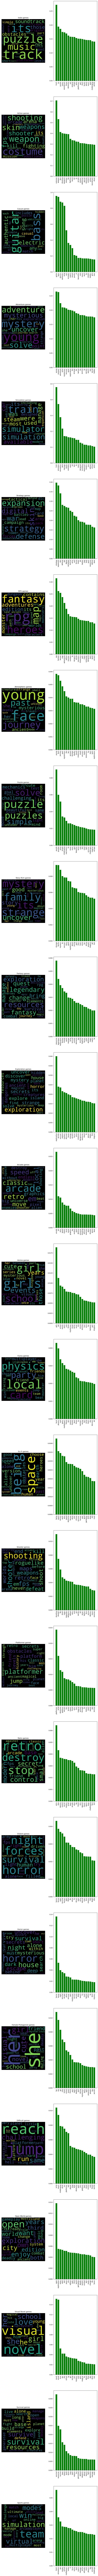

In [49]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axs = plt.subplots(len(top_tags), 2, figsize=(12,12*len(top_tags)), gridspec_kw={'hspace': 0.2})
i = 0

for genre in top_tags:
    genre_word_series = relative_freqs(genre,n_cutoff=1000,tag_cutoff=2,alphabet_only=True);
    
    app_desc_genre_dict = genre_word_series.to_dict()

    wc = WordCloud(background_color="black",width=1000,height=1000, max_words=30,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(app_desc_genre_dict)
    
    axs[i][0].set_title('{} games'.format(genre))
    axs[i][0].imshow(wc)
    
    axs[i][0].set_xticks([], [])
    axs[i][0].set_yticks([], [])
    
    genre_word_most_frequent = genre_word_series.nlargest(20).to_dict()
    
    axs[i][1].bar(genre_word_most_frequent.keys(), genre_word_most_frequent.values(), color='g')
    
    axs[i][1].tick_params(axis='x',rotation = 90)
    
    i += 1

plt.show()

The results are largely as expected. RPGs have words like "fantasy," "dungeon," and "heroes." There are some minor surprises, such as "horror" being the top word in atmospheric games. This is likely due to horror games commonly containing the "atmospheric" tag. We are labeling a game as "atmospheric" if the word "atmospheric" appears in the top 5 positions in its tag list, so this would make sense. If we set a stricter threshold (e.g., "atmospheric" must be the top tag), then we would likely see a different pattern, with each genre more differentiated from the others.

Next, I will explore the text of Steam reviews, and afterwards build some machine learning models to predict game genres. I am also planning to build a neural network to generate game descriptions and reviews of different genre games!